In [17]:
from __future__ import print_function, division
%matplotlib inline


import torch
import os
from torchvision import transforms, datasets, models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
torch.__version__

'0.4.1.post2'

In [2]:
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
data_dir = 'dataset'
image_dataset = datasets.ImageFolder(data_dir, data_transforms)

In [4]:
train_size = int(0.9 * len(image_dataset))
val_size = len(image_dataset) - train_size

In [5]:
train_dataset, valid_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [23]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size = 48, shuffle=True) 
dataloaders['valid'] = torch.utils.data.DataLoader(valid_dataset, batch_size = 48, shuffle=False)

In [29]:
class_names = image_dataset.classes
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [24]:
dataset_sizes = {'train': len(train_dataset), 'valid' : len(valid_dataset)}

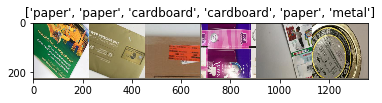

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print('-' * 10)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_ft = models.resnet50(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 1)

Epoch 0/0


RuntimeError: CUDA error: out of memory

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
torch.save(model_ft.state_dict(), 'smartbin_resnet50_00.pth')

In [31]:
model_ft.save('smartBin.pt')

AttributeError: 'ResNet' object has no attribute 'save'

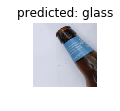

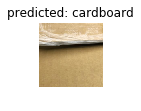

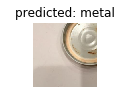

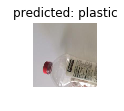

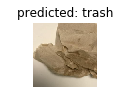

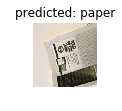

In [35]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [18]:
# model_conv = torchvision.models.resnet50(pretrained=True)

# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 102)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opoosed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/sa05975666/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:19<00:00, 5238781.01it/s]


In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8567 Acc: 0.8109
valid Loss: 0.3362 Acc: 0.9132

Epoch 1/24
----------
train Loss: 0.8546 Acc: 0.8103
valid Loss: 0.3146 Acc: 0.9083

Epoch 2/24
----------
train Loss: 0.8798 Acc: 0.8040
valid Loss: 0.3183 Acc: 0.9132

Epoch 3/24
----------
train Loss: 0.8746 Acc: 0.8033
valid Loss: 0.3439 Acc: 0.9095

Epoch 4/24
----------
train Loss: 0.8591 Acc: 0.8053
valid Loss: 0.3206 Acc: 0.9144

Epoch 5/24
----------
train Loss: 0.8738 Acc: 0.8065
valid Loss: 0.3136 Acc: 0.9193

Epoch 6/24
----------
train Loss: 0.8619 Acc: 0.8066
valid Loss: 0.3128 Acc: 0.9193

Epoch 7/24
----------
train Loss: 0.8620 Acc: 0.8127
valid Loss: 0.3071 Acc: 0.9193

Epoch 8/24
----------
train Loss: 0.8657 Acc: 0.8078
valid Loss: 0.3343 Acc: 0.9059

Epoch 9/24
----------
train Loss: 0.8765 Acc: 0.8028
valid Loss: 0.3091 Acc: 0.9193

Epoch 10/24
----------
train Loss: 0.8676 Acc: 0.8072
valid Loss: 0.3225 Acc: 0.9120

Epoch 11/24
----------
train Loss: 0.8585 Acc: 0.8082
valid Loss